# INTRODUCTION TO CUSTOM ASSESSMENT ANALYSIS

In Bonsai projects, logs are queried from Azure for two main reasons:
1. Ability to run whichever KPI metric was agreed with Subject Matter Experts. We want to convey training progress throughout experiments in the units the SMEs care about.
2. Transforming the custom assessment logs into graphs that are useful to guide conversations with the Subject Matter Experts.

There are two resources already available for you to check:
1. Query Custom Assessment Data - From DOCS
    - https://docs.microsoft.com/en-us/bonsai/cookbook/assessment/query-data
    - This doc contains the most updated step-by-step guide on the process.
2. Querying and Analyzing Logs from Project Bonsai - Jupyter NB
    - https://github.com/microsoft/bonsai-log-tools
    - This repo is the main resource that is refer to from the doc above. Feel free to click here if you already understand the main pipeline.

# 1. GETTING STARTED

This jupyter notebook focuses on the extraction of the custom assessments. It is a handy mirror of the jupyter notebook linked in the introduction above.

In this notebook, the logs are saved into a .CSV file. An independent notebook, named "JNB_Custom_Assessment_Analysis" will read the logs from that folder to perform the success and KPI analysis.

*By having 2 independent notebooks, we remove the need to re-extract and re-format the KQL logs when driving conversations with Subject Matter Experts.* 

## 1.1. Load Kqlmagic Extension

The following cell loads the `Kqlmagic` extension into your notebook and sets the maximum number of rows to display in the output to five (the result will not be truncated however, other than by KQL's [query limit](https://docs.microsoft.com/en-us/azure/data-explorer/kusto/concepts/querylimits)). Whenever you want to use `KQL` in a cell, prepend that cell with the statem `%%kql`.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


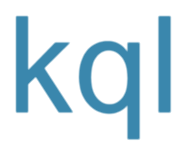

In [1]:
%reload_ext Kqlmagic
%config Kqlmagic.display_limit = 5 #limiting the number of rows displayed (full rows will still be stored)

## 1.2. Login to the log analytics workspace

Retrieve the `LOG_ANALYTICS_WORKSPACE_ID` using the instructions provided above. Please **note**, the log analytics workspace-id is the `workspace-id` of the log analytics workspace, **not** your Bonsai workspace!


In [2]:
# - [Reusing TODO]: Paste the WorkspaceID value from your LogAnalytics Resource in Azure -
LOG_ANALYTICS_WORKSPACE_ID = "729f7b19-3ds6-4144-b739-cd3v141bdse8"

# - [Reusing TODO]: Modify this alias as user identifier. i.e.: name_surname.
ALIAS = 'firstName_lastName' # could be anything, but should not be empty

%kql loganalytics://code;workspace=LOG_ANALYTICS_WORKSPACE_ID;alias=ALIAS

# - If your Azure subscription is in a different Azure Active Directory than your login id 
#   (your login is a guest in that directory), add the Azure subscription's AAD tenant ID to 
#   the connection string. Otherwise you may receive an InvalidAuthenticationTokenTenant error.
#
#   %kql loganalytics://code;workspace=LOG_ANALYTICS_WORKSPACE_ID;alias=ALIAS;tenant='AAD_TENANT_ID'

<IPython.core.display.Javascript object>

## 1.3. Specify Query Variables

In order to make our query specific to a brain version and brain name, we can create variables containing those values. The following cell does exactly that, and in addition specific a max number of rows to query.

In [3]:
# - [Reusing TODO]: Modify this section to point to the custom assessment of your choice -

# Define a tag for your assessment (to tag CSV filename).
assessment_name = "modular_brain_v1"

# Define the brain name and version to extract the logs.
brain_name = "modular_brain"
brain_version = 1

# Enter <assessment_id> of the custom assessment of interest. Leave blank to retrieve all assessment episodes.
#  You can get <assessment_id> by clicking on the "Access Data" button on your custom assessment (preview.bons.ai).
#assessment_id = ""
assessment_id = "f2065e40-ab03-4d08-bs2a-646e0069a22s"

In [4]:
# Estimate max number of rows expected based on number of assessment episodes, and the Episode Iteration Limit.
# - [Reusing TODO]: Increase these values if you modified the default values. Prevents infinite loop -
# --> number_of_episodes should be equal to the LessonAssessmentWindow (defaults at 30).
# --> episode_iteration_limit should be equal to the EpisodeIterationLimit (defaults at 1000).
number_of_episodes = 30  # 30 by default
episode_iteration_limit = 1000  # 1000 by default

number_of_rows = number_of_episodes * episode_iteration_limit

## 1.4. Query Corresponding Data

There are four tables generated by the Bonsai service and sent to your Log Analytics workspace. These are:

1. `EpisodeLog_CL` which contains your episode-level logs, such as information about the starting simulator configuration of your episodes, your aggregate goal metrics, etc.
2. `IterationLog_CL` which contains the interation-level logs of your simulator, including the actions received from the platform, and the states emitted from your simulators.
3. `ContainerEvent_CL` (**only for managed simulators that were logged with system logs**): container event logs such as image pull time, build time, etc.
4. `ContainerInstanceLog_CL` (**only for managed simulators that were logged with system logs**): system logs from your simulators.

Let's extract both iteration (`IterationLog_CL`) and episode-level (`EpisodeLog_CL`) logs and join them together via a KQL query. We then export the query results to a pandas dataframe which we can then manipulate and analyze.

**Note**: if this is the first time you're using logging you may need to wait for the first episode to finish so that episode-level logs are created and filled with at least 1 row of data.

#### Query

Here is our `KQL` query. Observe that we first filter the `EpisodeLog_CL` table to the brain name and brain version we defined above, and then join it with the `IterationLog_CL` table using the unique `EpisodeId_g` index. Finally, we select (using `project`) a set of columns we want to retain in our resulting dataframe.

In [5]:
%%kql
let _number_of_rows = number_of_rows;
let _brain_name = brain_name;
let _brain_version = brain_version;
let _assessment_id = assessment_id;
EpisodeLog_CL
  | where BrainName_s == _brain_name and
    BrainVersion_d == _brain_version and
    AssessmentId_g contains _assessment_id 
  | where  TimeGenerated > ago(60d)
  | join kind=inner (
      IterationLog_CL
      | sort by Timestamp_t desc
      ) on EpisodeId_g
  | take _number_of_rows
  | project 
      Timestamp = Timestamp_t,
      SessionIndex = SessionId_s,
      EpisodeId = EpisodeId_g,
      IterationIndex = IterationIndex_d,
      EpisodeType_s = EpisodeType_s,
      BrainName = BrainName_s,
      BrainVersion = BrainVersion_d,
      SimState = parse_json(SimState_s),
      SimAction = parse_json(SimAction_s),
      SelectedConcept =  SelectedConcept_s,
      SimConfig = parse_json(SimConfig_s),
      Reward = Reward_d,
      CumulativeReward = CumulativeReward_d,
      Terminal = Terminal_b,
      LessonIndex = LessonIndex_d,
      GoalMetrics = parse_json(GoalMetrics_s),
      EpisodeType = EpisodeType_s,
      FinishReason = FinishReason_s
  | order by SessionIndex, EpisodeId asc, IterationIndex asc

Timestamp,SessionIndex,EpisodeId,IterationIndex,EpisodeType_s,BrainName,BrainVersion,SimState,SimAction,SelectedConcept,SimConfig,Reward,CumulativeReward,Terminal,LessonIndex,GoalMetrics,EpisodeType,FinishReason
2022-07-20 00:18:58.254000+00:00,577026189_10.244.34.100,09889e08-fcc7-4824-86ac-cd241b36511e,1,Assessment,lunarlander_0701,16,"{'x_position': -0.005960273556411266, 'y_position': 1.5457725524902344, 'x_velocity': -0.01939162239432335, 'y_velocity': 0.14891417324543, 'angle': 0.080194853246212, 'rotation': 0.07360221445560455, 'left_leg': 0, 'right_leg': 0, 'gym_reward': -1.934706190934412, 'gym_terminal': False, 'randomized_strength': 1, 'randomized_steps': 28, 'prev_x_position': -0.005803585052490234, 'prev_y_position': 1.5424176454544067, 'prev_x_velocity': -0.01488879043608904, 'prev_y_velocity': 0.138965904712677, 'prev_engine1': 0.26755350004145595, 'prev_engine2': -0.11583628187128614, 'concept': 0}",None,TransfActionStop,"{'hold_selected_concept': 1, 'randomized_steps': 28}",0,171.920715332031,False,0,"{'avoidGoalMetrics': [{'goal_index': 0, 'goal_satisfaction_rate': 1, 'automata_output': {'target': ['range', '-Infinity', -90], 'value': [100], 'reward': 1, 'current_return': 488.4611032154127}, 'robustness': 0.7652740267317877, 'success_per_dimension': [1], 'success': 1}], 'minimizeGoalMetrics': [{'goal_index': 1, 'final_value': 0.023404428735375404, 'total_value': 101.24269013106824, 'distance': -0.0765955712646246, 'success': -1, 'mean_value': 0.20248538026213647, 'automata_output': {'current_return': -16.887302257116332, 'reward': 0.10010985298003948, 'value': [0.023404428735375404], 'target': ['range', '-Infinity', 0.1]}, 'robustness': -0.07253260256137396, 'goal_satisfaction_rate': 0.963733698719313}, {'goal_index': 2, 'distance': -1.100000023841858, 'total_value': -747, 'success': 1, 'automata_output': {'target': ['range', '-Infinity', -0.8999999761581421], 'reward': 1.100000023841858, 'value': [-2], 'current_return': 285.40000915527344}, 'robustness': 0.16250000917911542, 'final_value': -2, 'mean_value': -1.494, 'goal_satisfaction_rate': 1}, {'goal_satisfaction_rate': 1, 'total_value': 70.94826457466716, 'success': 1, 'goal_index': 3, 'final_value': 0, 'automata_output': {'current_return': 100.59422746364687, 'target': ['range', '-Infinity', 0.2], 'value': [0], 'reward': 0.35520517508455257}, 'robustness': 0.051106230476659215, 'distance': -0.2, 'mean_value': 0.14189652914933432}, {'goal_satisfaction_rate': 1, 'goal_index': 4, 'distance': -1.5, 'total_value': 91.82717123627664, 'success': 1, 'mean_value': 0.18365434247255324, 'final_value': 0, 'automata_output': {'value': [0], 'target': ['range', '-Infinity', 1.5], 'reward': 1.7951591140842795, 'current_return': 797.7883716245468}, 'robustness': 0.797255905720767}]}",Assessment,Interrupted
2022-07-20 00:18:58.563000+00:00,577026189_10.244.34.100,09889e08-fcc7-4824-86ac-cd241b36511e,2,Assessment,lunarlander_0701,16,"{'x_position': -0.006117057986557484, 'y_position': 1.548527717590332, 'x_velocity': -0.019391488283872604, 'y_velocity': 0.1222463846206665, 'angle': 0.08387496322393417, 'rotation': 0.07360214740037918, 'left_leg': 0, 'right_leg': 0, 'gym_reward': 1.996076495375462, 'gym_terminal': False, 'randomized_strength': 1, 'randomized_steps': 28, 'prev_x_position': -0.005960273556411266, 'prev_y_position': 1.5457725524902344, 'prev_x_velocity': -0.01939162239432335, 'prev_y_velocity': 0.14891417324543, 'prev_engine1': 0, 'prev_engine2': 0, 'concept': 0}","{'engine1': 0, 'engine2': 0, 'concept': 5}",TransfActionStop,"{'hold_selected_concept': 1, 'randomized_steps': 28}",-0.350877192982456,171.920715332031,False,0,"{'avoidGoalMetrics': [{'goal_index': 0, 'goal_satisfaction_rate': 1, 'automata_output': {'target': ['range', '-Infinity', -90], 'value': [100], 'reward': 1, 'current_return': 488.4611032154127}, 'robustness': 0.7652740267317877, 'success_per_dimension': [1], 'success': 1}], 'minimizeGoalMetrics': [{'goal_index': 1, 'final_value': 0.0234044287

[{'Timestamp': datetime.datetime(2022, 7, 20, 0, 18, 58, 254000, tzinfo=tzutc()), 'SessionIndex': '577026189_10.244.34.100', 'EpisodeId': '09889e08-fcc7-4824-86ac-cd241b36511e', 'IterationIndex': 1, 'EpisodeType_s': 'Assessment', 'BrainName': 'lunarlander_0701', 'BrainVersion': 16, 'SimState': {'x_position': -0.005960273556411266, 'y_position': 1.5457725524902344, 'x_velocity': -0.01939162239432335, 'y_velocity': 0.14891417324543, 'angle': 0.080194853246212, 'rotation': 0.07360221445560455, 'left_leg': 0, 'right_leg': 0, 'gym_reward': -1.934706190934412, 'gym_terminal': False, 'randomized_strength': 1, 'randomized_steps': 28, 'prev_x_position': -0.005803585052490234, 'prev_y_position': 1.5424176454544067, 'prev_x_velocity': -0.01488879043608904, 'prev_y_velocity': 0.138965904712677, 'prev_engine1': 0.26755350004145595, 'prev_engine2': -0.11583628187128614, 'concept': 0}, 'SimAction': None, 'SelectedConcept': 'TransfActionStop', 'SimConfig': {'hold_selected_concept': 1, 'randomized_steps': 28}, 'Reward': 0, 'CumulativeReward': 171.920715332031, 'Terminal': False, 'LessonIndex': 0, 'GoalMetrics': {'avoidGoalMetrics': [{'goal_index': 0, 'goal_satisfaction_rate': 1, 'automata_output': {'target': ['range', '-Infinity', -90], 'value': [100], 'reward': 1, 'current_return': 488.4611032154127}, 'robustness': 0.7652740267317877, 'success_per_dimension': [1], 'success': 1}], 'minimizeGoalMetrics': [{'goal_index': 1, 'final_value': 0.023404428735375404, 'total_value': 101.24269013106824, 'distance': -0.0765955712646246, 'success': -1, 'mean_value': 0.20248538026213647, 'automata_output': {'current_return': -16.887302257116332, 'reward': 0.10010985298003948, 'value': [0.023404428735375404], 'target': ['range', '-Infinity', 0.1]}, 'robustness': -0.07253260256137396, 'goal_satisfaction_rate': 0.963733698719313}, {'goal_index': 2, 'distance': -1.100000023841858, 'total_value': -747, 'success': 1, 'automata_output': {'target': ['range', '-Infinity', -0.8999999761581421], 'reward': 1.100000023841858, 'value': [-2], 'current_return': 285.40000915527344}, 'robustness': 0.16250000917911542, 'final_value': -2, 'mean_value': -1.494, 'goal_satisfaction_rate': 1}, {'goal_satisfaction_rate': 1, 'total_value': 70.94826457466716, 'success': 1, 'goal_index': 3, 'final_value': 0, 'automata_output': {'current_return': 100.59422746364687, 'target': ['range', '-Infinity', 0.2], 'value': [0], 'reward': 0.35520517508455257}, 'robustness': 0.051106230476659215, 'distance': -0.2, 'mean_value': 0.14189652914933432}, {'goal_satisfaction_rate': 1, 'goal_index': 4, 'distance': -1.5, 'total_value': 91.82717123627664, 'success': 1, 'mean_value': 0.18365434247255324, 'final_value': 0, 'automata_output': {'value': [0], 'target': ['range', '-Infinity', 1.5], 'reward': 1.7951591140842795, 'current_return': 797.7883716245468}, 'robustness': 0.797255905720767}]}, 'EpisodeType': 'Assessment', 'FinishReason': 'Interrupted'},
 {'Timestamp': datetime.datetime(2022, 7, 20, 0, 18, 58, 563000, tzinfo=tzutc()), 'SessionIndex': '577026189_10.244.34.100', 'EpisodeId': '09889e08-fcc7-4824-86ac-cd241b36511e', 'IterationIndex': 2, 'EpisodeType_s': 'Assessment', 'BrainName': 'lunarlander_0701', 'BrainVersion': 16, 'SimState': {'x_position': -0.006117057986557484, 'y_position': 1.548527717590332, 'x_velocity': -0.019391488283872604, 'y_velocity': 0.1222463846206665, 'angle': 0.08387496322393417, 'rotation': 0.07360214740037918, 'left_leg': 0, 'right_leg': 0, 'gym_reward': 1.996076495375462, 'gym_terminal': False, 'randomized_strength': 1, 'randomized_steps': 28, 'prev_x_position': -0.005960273556411266, 'prev_y_position': 1.5457725524902344, 'prev_x_velocity': -0.01939162239432335, 'prev_y_velocity': 0.14891417324543, 'prev_engine1': 0, 'prev_engine2': 0, 'concept': 0}, 'SimAction': {'engine1': 0, 'engine2': 0, 'concept': 5}, 'SelectedConcept': 'TransfActionStop', 'SimConfig': {'hold_selected_concept': 1, 'randomized_steps': 28}, 'Reward': -0.350877192982456, 'CumulativeReward': 171.920715

## 1.5. Magic

Magically, the output of the result is saved to a new python variable called `_kql_raw_result`. We can convert this to a pandas dataframe:

In [6]:
# convert query results in a dataframe
iter_df = _kql_raw_result_.to_dataframe()
iter_df.head(5)

,Timestamp,SessionIndex,EpisodeId,IterationIndex,EpisodeType_s,BrainName,BrainVersion,SimState,SimAction,SelectedConcept,SimConfig,Reward,CumulativeReward,Terminal,LessonIndex,GoalMetrics,EpisodeType,FinishReason
0,2022-07-20 00:18:58.254000+00:00,577026189_10.244.34.100,09889e08-fcc7-4824-86ac-cd241b36511e,1.0,Assessment,lunarlander_0701,16.0,"{'x_position': -0.005960273556411266, 'y_posit...",None,TransfActionStop,"{'hold_selected_concept': 1, 'randomized_steps...",0.000000,171.920715,False,0.0,"{'avoidGoalMetrics': [{'goal_index': 0, 'goal_...",Assessment,Interrupted
1,2022-07-20 00:18:58.563000+00:00,577026189_10.244.34.100,09889e08-fcc7-4824-86ac-cd241b36511e,2.0,Assessment,lunarlander_0701,16.0,"{'x_position': -0.006117057986557484, 'y_posit...","{'engine1': 0, 'engine2': 0, 'concept': 5}",TransfActionStop,"{'hold_selected_concept': 1, 'randomized_steps...",-0.350877,171.920715,False,0.0,"{'avoidGoalMetrics': [{'goal_index': 0, 'goal_...",Assessment,Interrupted
2,2022-07-20 00:18:58.581000+00:00,577026189_10.244.34.100,09889e08-fcc7-4824-86ac-cd241b36511e,3.0,Assessment,lunarlander_0701,16.0,"{'x_position': -0.006273746490478516, 'y_posit...","{'engine1': 0, 'engine2': 0, 'concept': 5}",TransfActionRight,"{'hold_selected_concept': 1, 'randomized_steps...",-0.350877,171.920715,False,0.0,"{'avoidGoalMetrics': [{'goal_index': 0, 'goal_...",Assessment,Interrupted
3,2022-07-20 00:18:58.600000+00:00,577026189_10.244.34.100,09889e08-fcc7-4824-86ac-cd241b36511e,4.0,Assessment,lunarlander_0701,16.0,"{'x_position': -0.006374550051987171, 'y_posit...","{'engine1': -0.1512366235256195, 'concept': 1,...",TransfActionStop,"{'hold_selected_concept': 1, 'randomized_steps...",-0.350877,171.920715,False,0.0,"{'avoidGoalMetrics': [{'goal_index': 0, 'goal_...",Assessment,Interrupted
4,2022-07-20 00:18:58.641000+00:00,577026189_10.244.34.100,09889e08-fcc7-4824-86ac-cd241b36511e,5.0,Assessment,lunarlander_0701,16.0,"{'x_position': -0.006475353147834539, 'y_posit...","{'engine2': 0, 'concept': 5, 'engine1': 0}",TransfActionRight,"{'hold_selected_concept': 1, 'randomized_steps...",-0.350877,171.920715,False,0.0,"{'avoidGoalMetrics': [{'goal_index': 0, 'goal_...",Assessment,Interrupted


## 1.6. Converting Nested Array Into New Columns

Notice that the array-data as stored in `SimState`, `SimAction` and `SimConfig` are dictionaries. You can cast them into new columns using the operations below:

In [7]:
import pandas as pd
import numpy as np
import copy

def format_kql_logs(df: pd.DataFrame) -> pd.DataFrame:
    ''' Function to format a dataframe obtained from KQL query.
        Output format: keeps only selected columns, and flatten nested columns [SimAction, SimState, SimConfig]

        Parameters
        ----------
        df : DataFrame
            dataframe obtained from running KQL query then exporting `_kql_raw_result_.to_dataframe()`
    '''
    # Copying dataframe to avoid re-applying transformations if several calls are made to the same dataset.
    df = copy.deepcopy(df)
    
    # TRANSFORM EPISODE ID INTO EPISODE INDEX. Also, make iteration index be an integer.
    episode_id_to_idx = dict([(ep_id, idx) for idx,ep_id in enumerate(iter_df["EpisodeId"].unique())])
    df['EpisodeIndex'] = df['EpisodeId'].apply(lambda ep_id: episode_id_to_idx[ep_id])
    df['IterationIndex'] = df['IterationIndex'].apply(lambda it_idx: int(it_idx))
    
    # SHIFT ACTIONS BY ONE, WHENEVER THE FIRST ITERATION HAS A NONE ACTION
    # - Only apply shift for as long as logs are saved having actions paired with their resulting state -
    # -- When shifting, we transform added NaN rows to become None for later correct unpacking of action dicts. --
    if df.loc()[0]['SimAction'] is None:
        df['SimAction'] = df.groupby("EpisodeIndex")['SimAction'].shift(-1).replace({np.nan:None})
    
    # SELECT COLUMNS OF INTEREST, including nested columns.
    selected_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "SelectedConcept", "SimState", "SimAction", "SimConfig"]
    nested_columns =  [ "SimState", "SimAction", "SimConfig"]
    nested_columns_prefix =  [ "state_", "action_", "config_"]
    df_selected_columns = df[selected_columns]
    
    # UNPACK NESTED COLUMNS, EACH INTO THEIR OWN INDIVIDUAL COLUMN.
    series_lst = []
    ordered_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "SelectedConcept", "IterationSpeed"]
    for i,i_prefix in zip(nested_columns, nested_columns_prefix):
        # Create a series out of the dictionaries contained in each nested column.
        new_series = df_selected_columns[i].apply(pd.Series)
        column_names = new_series.columns.values.tolist()
        
        # Continue with next nested column if current one is empty.
        if len(column_names) < 1:
            # Delete nested column.
            del(df_selected_columns[i])
            continue
        
        # Add prefix to the new columns. Delete previous ones.
        for idx,column_n in enumerate(column_names):
            new_column_n = i_prefix + column_n
            column_names[idx] = new_column_n
            new_series[new_column_n] = new_series[column_n]
            del(new_series[column_n])
        
        # Extend target columns, and append created series to list.
        ordered_columns.extend(column_names)
        series_lst.append(new_series)
        
        # Delete nested column from original dataframe.
        del(df_selected_columns[i])

    # Format DF with the target columns (original ones, plus unnested new ones.)
    series_lst.append(df_selected_columns)
    formated_df = pd.concat(series_lst, axis=1)
    formated_df = formated_df.sort_values(by=['EpisodeIndex','Timestamp'],ascending=True) # reorder df based on Timestamp
    formated_df.index = range(len(formated_df)) # re-index
    formated_df['Timestamp']=pd.to_datetime(formated_df['Timestamp']) # convert Timestamp to datetime
    formated_df['IterationSpeed']=formated_df.groupby('EpisodeIndex')['Timestamp'].diff().dt.total_seconds() # convert Timestamp to datetime
    
    formated_df = formated_df[ordered_columns]
    
    # REMOVE SELECTED CONCEPT COLUMN, for those brains without selectors
    if formated_df["SelectedConcept"].unique()[0] == "":
        del formated_df["SelectedConcept"]
    
    return formated_df.sort_values(by=["EpisodeIndex", "IterationIndex"])


In [8]:
df_cleaned = format_kql_logs(iter_df)
print(f"Your dataset has been correctly read.\nState, action, and config columns have been unpacked into individual columns.")
print(f"\nNote, your custom assessment contains a total of {len(df_cleaned)} iterations.")

# Iteration time
it_time = df_cleaned["IterationSpeed"].mean()
it_time = np.round(it_time, decimals=3)
print(f"\nYour simulation average iteration speed is {it_time} seconds.")

Your dataset has been correctly read.
State, action, and config columns have been unpacked into individual columns.

Note, your custom assessment contains a total of 14307 iterations.

Your simulation average iteration speed is 0.027 seconds.


In [9]:
df_cleaned.head(5)

,Timestamp,EpisodeIndex,IterationIndex,Reward,Terminal,SelectedConcept,IterationSpeed,state_x_position,state_y_position,state_x_velocity,...,state_prev_x_velocity,state_prev_y_velocity,state_prev_engine1,state_prev_engine2,state_concept,action_engine1,action_engine2,action_concept,config_hold_selected_concept,config_randomized_steps
0,2022-07-20 00:18:58.254000+00:00,0,1,0.000000,False,TransfActionStop,NaN,-0.005960,1.545773,-0.019392,...,-0.014889,0.138966,0.267554,-0.115836,0,0.000000,0.000000,5.0,1,28
1,2022-07-20 00:18:58.563000+00:00,0,2,-0.350877,False,TransfActionStop,0.309,-0.006117,1.548528,-0.019391,...,-0.019392,0.148914,0.000000,0.000000,0,0.000000,0.000000,5.0,1,28
2,2022-07-20 00:18:58.581000+00:00,0,3,-0.350877,False,TransfActionRight,0.018,-0.006274,1.550683,-0.019391,...,-0.019391,0.122246,0.000000,0.000000,0,-0.151237,0.843603,1.0,1,28
3,2022-07-20 00:18:58.600000+00:00,0,4,-0.350877,False,TransfActionStop,0.019,-0.006375,1.552250,-0.012363,...,-0.019391,0.095579,-0.151237,0.843603,0,0.000000,0.000000,5.0,1,28
4,2022-07-20 00:18:58.641000+00:00,0,5,-0.350877,False,TransfActionRight,0.041,-0.006475,1.553216,-0.012363,...,-0.012363,0.069494,0.000000,0.000000,0,-0.172418,0.934626,1.0,1,28


### 1.7. Save Transformed Assessment Data

**Note, if you want to compare several assessment policies, select a name for each assessment you want to query in the 'Optional' section 1.3.1.**

Running this cell adds a new entry to the comparison dictionary. The key is 'select_assessment', and the value is the latest KQL data transformed into a Pandas DataFrame ('df_cleaned').

In [10]:
import os
import datetime

# If assessment name is not defined, generate a default value.
if not assessment_name:
    assessment_name = str(brain_name) +"_"+ str(brain_version)

# Add Custom Assessment attributes as columns.
df_cleaned["custom_assessment_tag"] = assessment_name
df_cleaned["brain_name"] = brain_name
df_cleaned["brain_version"] = brain_version
df_cleaned["assessment_id"] = assessment_id


# Define output folder where the formatted DataFrame will be stored
out_csv_subfolder = "kql_logs"
out_csv_folder = os.path.join(os.getcwd(), out_csv_subfolder)

if not os.path.exists(out_csv_folder):
    os.mkdir(out_csv_folder)
    print("Created filepath for logs.")

print('Output folder were logs will be extracted:\n', out_csv_folder)


# Create pretag to identify the custom assessment.
pretag = "CustomAssess_"
# Create MMDD time tag to identify the month and day of the extraction.
dt_now = datetime.datetime.now()
now_month = str(dt_now.month).rjust(2, '0')
now_day = str(dt_now.day).rjust(2, '0')
time_tag = "_" + now_month + now_day

# Define assessment name (appending time tag) and save to csv.
assessment_filename = pretag + assessment_name + time_tag + ".csv"
out_csv_filepath = os.path.join(out_csv_folder, assessment_filename)
# Save DataFrame to CSV.
df_cleaned.to_csv(out_csv_filepath)


print(f"\nNew assessment has been saved into: {out_csv_filepath}")
print(f"\nAssessment saved: '{assessment_filename}'.")

Output folder were logs will be extracted:
 C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs

New assessment has been saved into: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs\CustomAssess_modular_brain_0803.csv

Assessment saved: 'CustomAssess_modular_brain_0803.csv'.


## 1.8. Summary

**Up to this point, we have performed the following operations**:
1. Load KQL.
2. Log in to your analytics workspace.
3. Define the query variables for our custom assessment.
4. Extract the per-iteration information for all episodes within our assessment.
5. Convert the KQL query into a Pandas DataFrame.
6. Unpack the dictionaries from SimState, SimAction, and SimConfig.
7. Save to CSV file on 'kql_logs' folder.